# Fine-Tune YOLOv12 for Construction Safety Detection

This notebook demonstrates how to fine-tune the YOLOv12 object detection model on a custom dataset of construction safety. We'll go through environment setup, training, evaluation, and inference steps.

## Environment setup

### Step 1: Install Dependencies

We install the required packages:
- `ultralytics`: Official package to use YOLO models including the new YOLOv12.
- `supervision`: A toolset for evaluating and visualizing object detection results.

In [ ]:
!pip install -qU ultralytics supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 17.1 MB/s eta 0:00:00


### Step 2: Check GPU Availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Nov 15 12:27:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Step 3: Set Working Directory

This sets up the current working directory and store in a variable for use later when accessing files or saving models, and prints it for confirmation.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 4: Prepare the Dataset

Instructions:
1.	Go to Google Drive of this hands-on, and copy the dataset ZIP file (rock-paper-scissors-14.zip) into your My Drive.
You can place it under a new folder named datasets or directly under My Drive.
2.	In the left sidebar of Colab, go to the Files tab (📁 icon), and click “Mount Drive”.
3.	Once mounted, your Google Drive will be available under the path: /content/drive/MyDrive/.
4.	Find the path to your dataset file (right-click → Copy path).
5.	Replace the SOURCE PATH below with your copied path, then copy it into your working directory and unzip:

In [ ]:
# Copy the dataset ZIP to the current working directory
!scp -r '/content/drive/MyDrive/E-Course dan Bootcamp/Purwadhika/Capstone Project/capstone 4/construction_safety.v1i.yolov12.zip' . # REPLACE THE SOURCE PATH WITH YOURS -> /content/drive/MyDrive/datasets/rock-paper-scissors-14.zip

Unzips the dataset containing labeled images for rock, paper, and scissors.

In [ ]:
# Unzip the dataset
!unzip /content/construction_safety.v1i.yolov12.zip

Archive:  /content/construction_safety.v1i.yolov12.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/ppe_0000_jpg.rf.7960e8f628d8a3fc17c6b858dec87a64.jpg  
 extracting: test/images/ppe_0004_jpg.rf.0a9886fc2b97ff81ff4ac5727ef66148.jpg  
 extracting: test/images/ppe_0008_jpg.rf.f3da9c637440a2a4dd256520f2f2e765.jpg  
 extracting: test/images/ppe_0009_jpg.rf.46d6856348dc2ed1e531bb1bc17983f7.jpg  
 extracting: test/images/ppe_0013_jpg.rf.f1bbbf35f9f80c25bd2744171b83ae6f.jpg  
 extracting: test/images/ppe_0014_jpg.rf.5b90e4a7707532584cbf89590d6f1e13.jpg  
 extracting: test/images/ppe_0038_jpg.rf.baf07f7ec6f9fdc82334d58a5a1e6db4.jpg  
 extracting: test/images/ppe_0058_jpg.rf.85334d41a89e79c1ce40b93d32338a3f.jpg  
 extracting: test/images/ppe_0094_jpg.rf.28111b2038f03030f229af28cdbe3484.jpg  
 extracting: test/images/ppe_0104_jpg.rf.8cd1e29b3e584494be060ccbd

### Step 5: Dataset Overview

- Sets dataset location in a variable.
- Lists the contents of the dataset.
- Displays the data.yaml configuration file.

`data.yaml` tells YOLO where to find training/validation images, and which class labels are being used.


In [ ]:
dataset_location = "/content/"

In [ ]:
!ls {dataset_location}

construction_safety.v1i.yolov12.zip  README.dataset.txt   test
data.yaml			     README.roboflow.txt  train
drive				     sample_data	  valid


In [ ]:
!cat {dataset_location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 5
names: ['helmet', 'no-helmet', 'no-vest', 'person', 'vest']

roboflow:
  workspace: personal-project-kej16
  project: construction-safety-gsnvb-jl6el
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/personal-project-kej16/construction-safety-gsnvb-jl6el/dataset/1

### Step 6: Download Pretrained YOLOv12 Weights

Downloads a pretrained YOLOv12 nano model (`yolov12n.pt`) to be fine-tuned.

In [ ]:
!wget https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12n.pt

--2025-11-11 12:22:59--  https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12n.pt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/928546208/99db71db-0946-4c10-94a0-b54baf471037?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-11T13%3A02%3A32Z&rscd=attachment%3B+filename%3Dyolov12n.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-11T12%3A01%3A57Z&ske=2025-11-11T13%3A02%3A32Z&sks=b&skv=2018-11-09&sig=lBhCgrdnHsvJBHMoS1B6GkVHkrr1Clcmjf5pDciGMl4%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2Mjg2NDA3OSwibmJmIjoxNzYyODYzNzc5LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcm

In [ ]:
!wget https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12m.pt

--2025-11-11 13:06:18--  https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12m.pt
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/928546208/d0bab906-b31c-49f1-8e11-e513e346a24a?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-11T14%3A00%3A15Z&rscd=attachment%3B+filename%3Dyolov12m.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-11T12%3A59%3A19Z&ske=2025-11-11T14%3A00%3A15Z&sks=b&skv=2018-11-09&sig=Hh45jxTWu6WOiVgKnzY%2FEPWCDw4s6k5v67uYyFUJHhc%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2Mjg2ODE3OCwibmJmIjoxNzYyODY2Mzc4LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNv

### Step 7: Load Pretrained YOLO Model

Initializes the YOLO model using the downloaded weights.

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Step 8: Train the Model

Fine-tune YOLOv12 using our dataset for 50 epochs.
Parameters include:
- `data`: path to YAML config
- `epochs`: total number of training epochs
- `batch`: number of images per batch
- `imgsz`: input image size
- `patience`: early stopping if no improvement
- `save_period`: save model checkpoint every 5 epochs
- `val`: whether to validate
- `flipud`: probability of vertical flip augmentation

Trains YOLOv12 model on your dataset and saves it under runs/detect/train.


In [ ]:
results = model.train(
        data=f'{dataset_location}/data.yaml', # Using 20 epochs for faster training
        epochs=50,
        batch=16,
        imgsz=640,
        exist_ok=True,
        patience=5,              # Early stopping if no improvement for 5 epochs
        save_period=5,           # Save checkpoints every 5 epochs
        val=True,                # Ensure validation is performed
        verbose=True,            # Show detailed output during training
        flipud=0.5,              # Augmentation using vertical flip probability
)

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content//data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov12m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretra

## Evaluation

### Step 9: Post-training Setup

Fix for character encoding and display directory structure for output artifacts.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Lists training artifacts such as weights, result plots, and confusion matrix.
!ls {HOME}/runs/detect/train/

args.yaml			 labels.jpg		val_batch0_pred.jpg
BoxF1_curve.png			 results.csv		val_batch1_labels.jpg
BoxP_curve.png			 results.png		val_batch1_pred.jpg
BoxPR_curve.png			 train_batch0.jpg	val_batch2_labels.jpg
BoxR_curve.png			 train_batch1.jpg	val_batch2_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg	weights
confusion_matrix.png		 val_batch0_labels.jpg


### Step 10: Visualize Training Results

Display the confusion matrix and training result curves from the YOLO training run. The confusion matrix: how well the model distinguishes between classes.

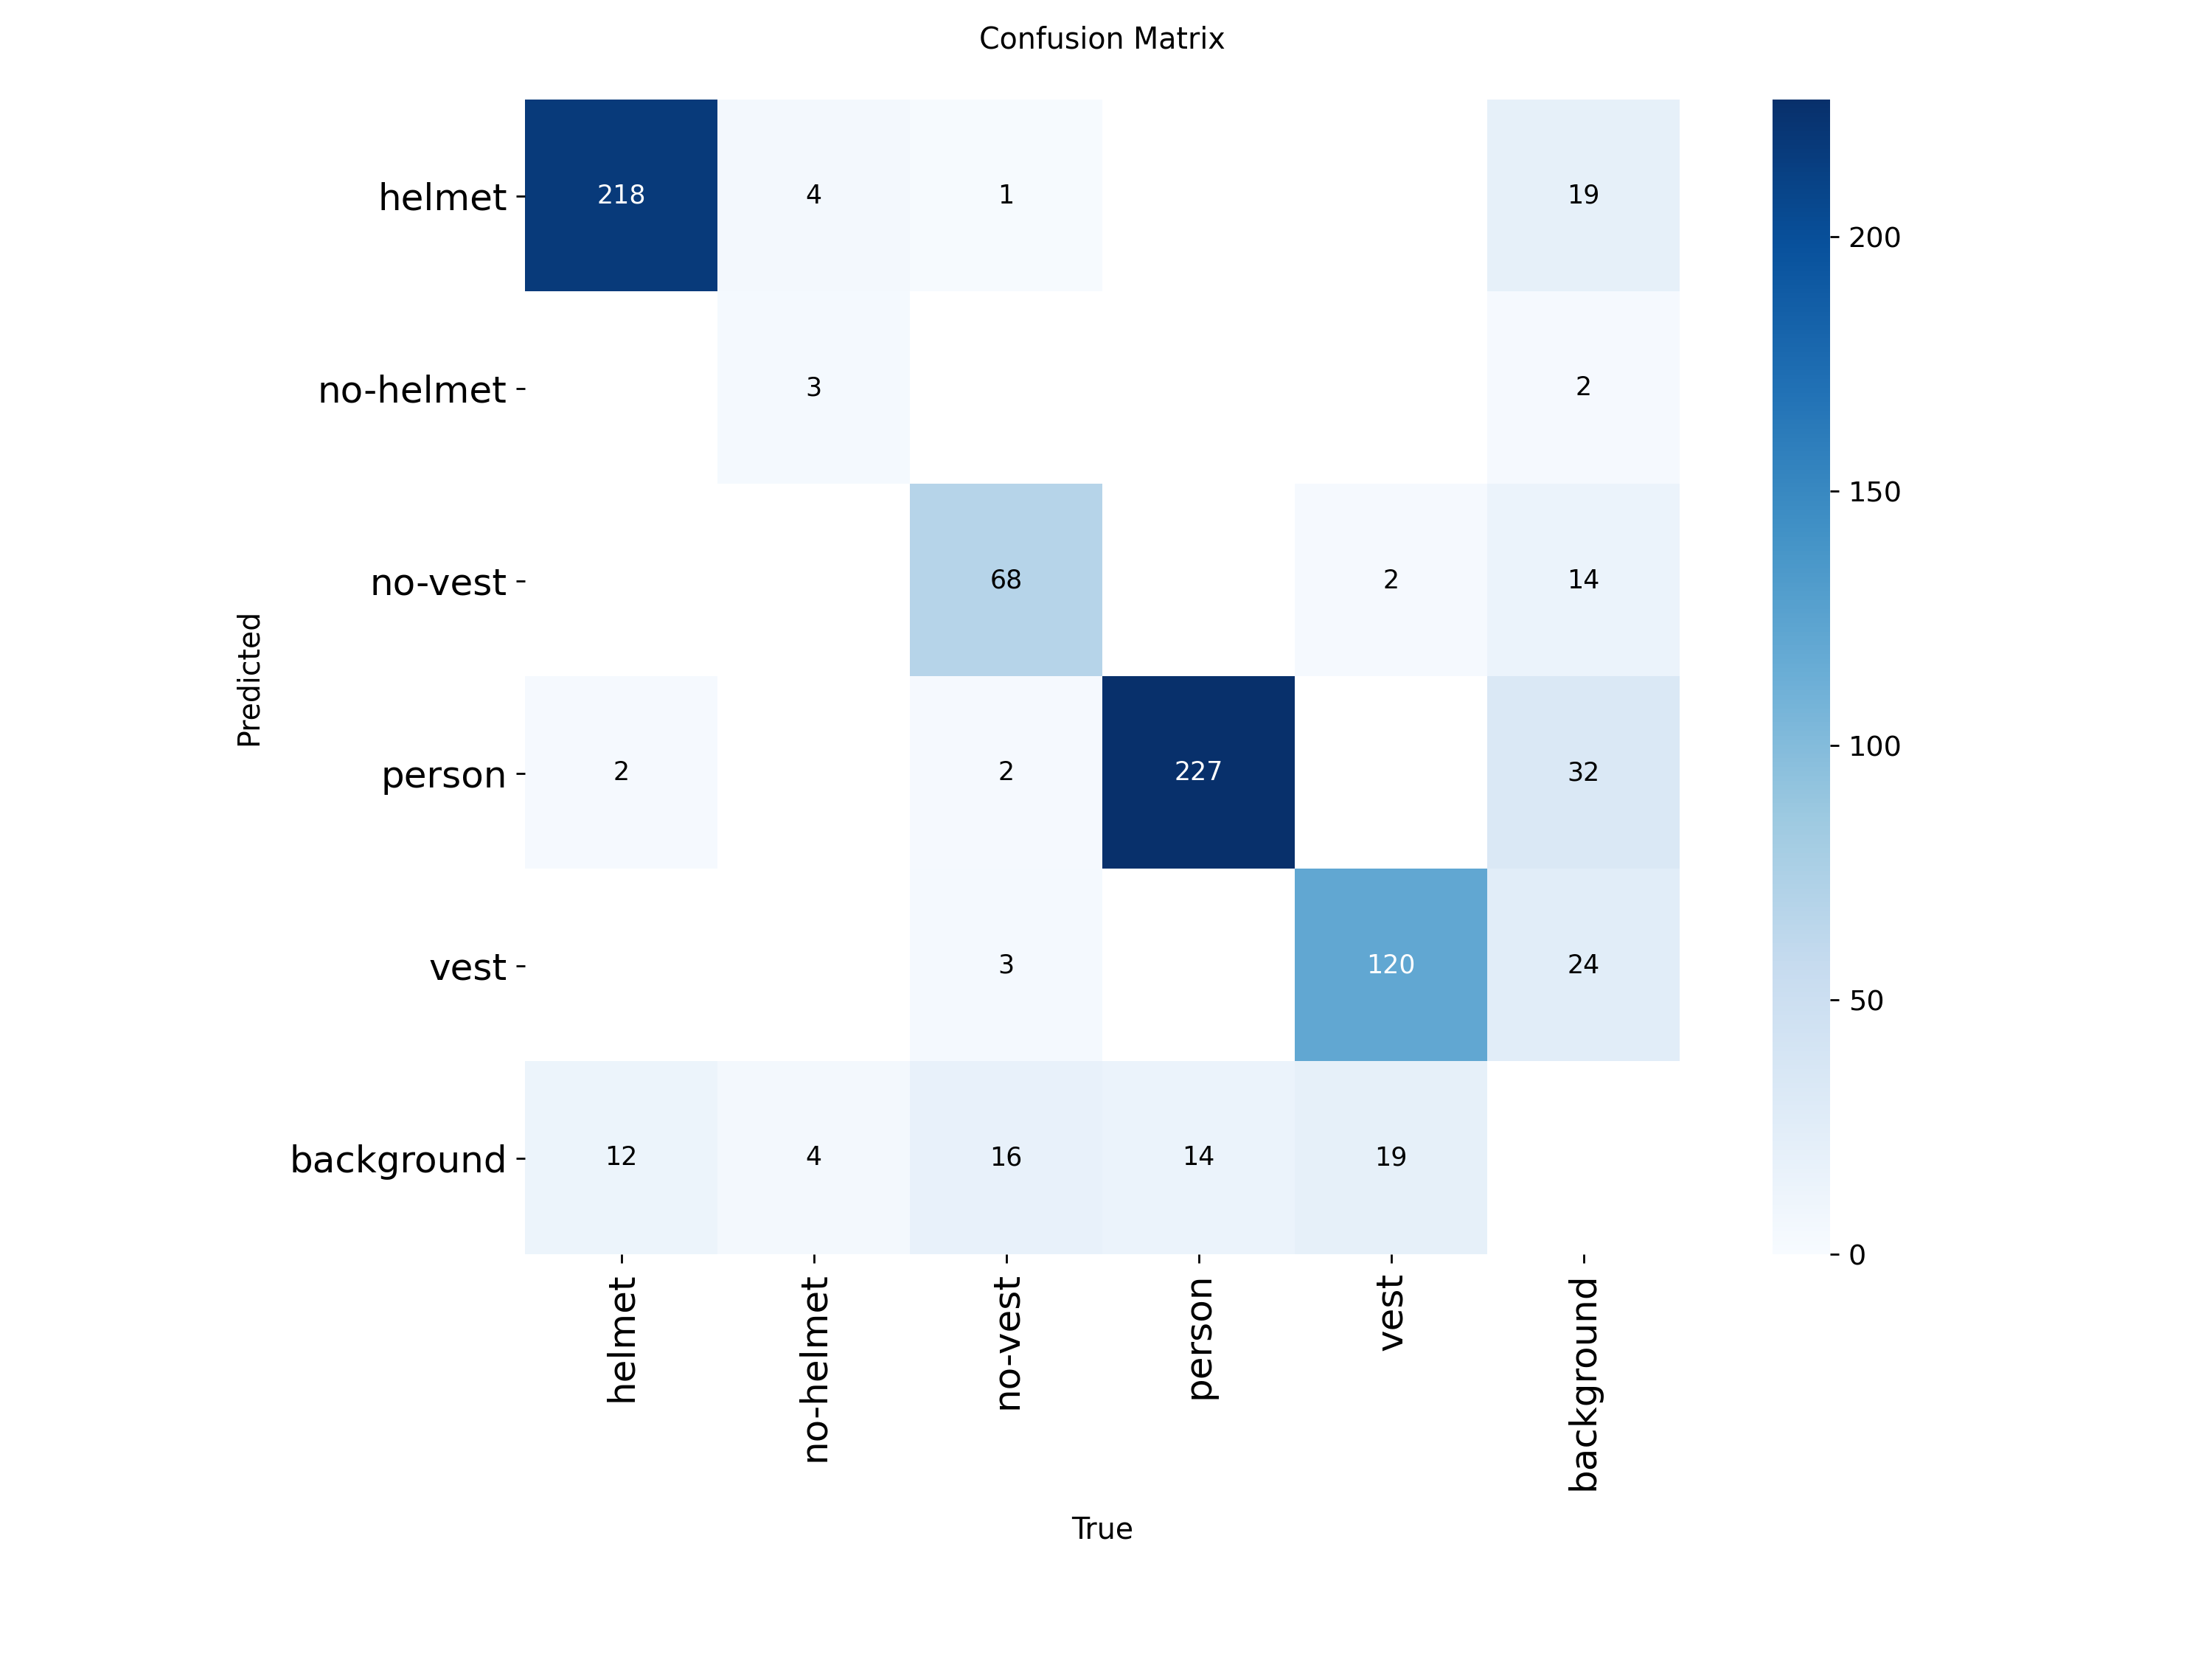

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

The training graph: loss, mAP, precision/recall over time.

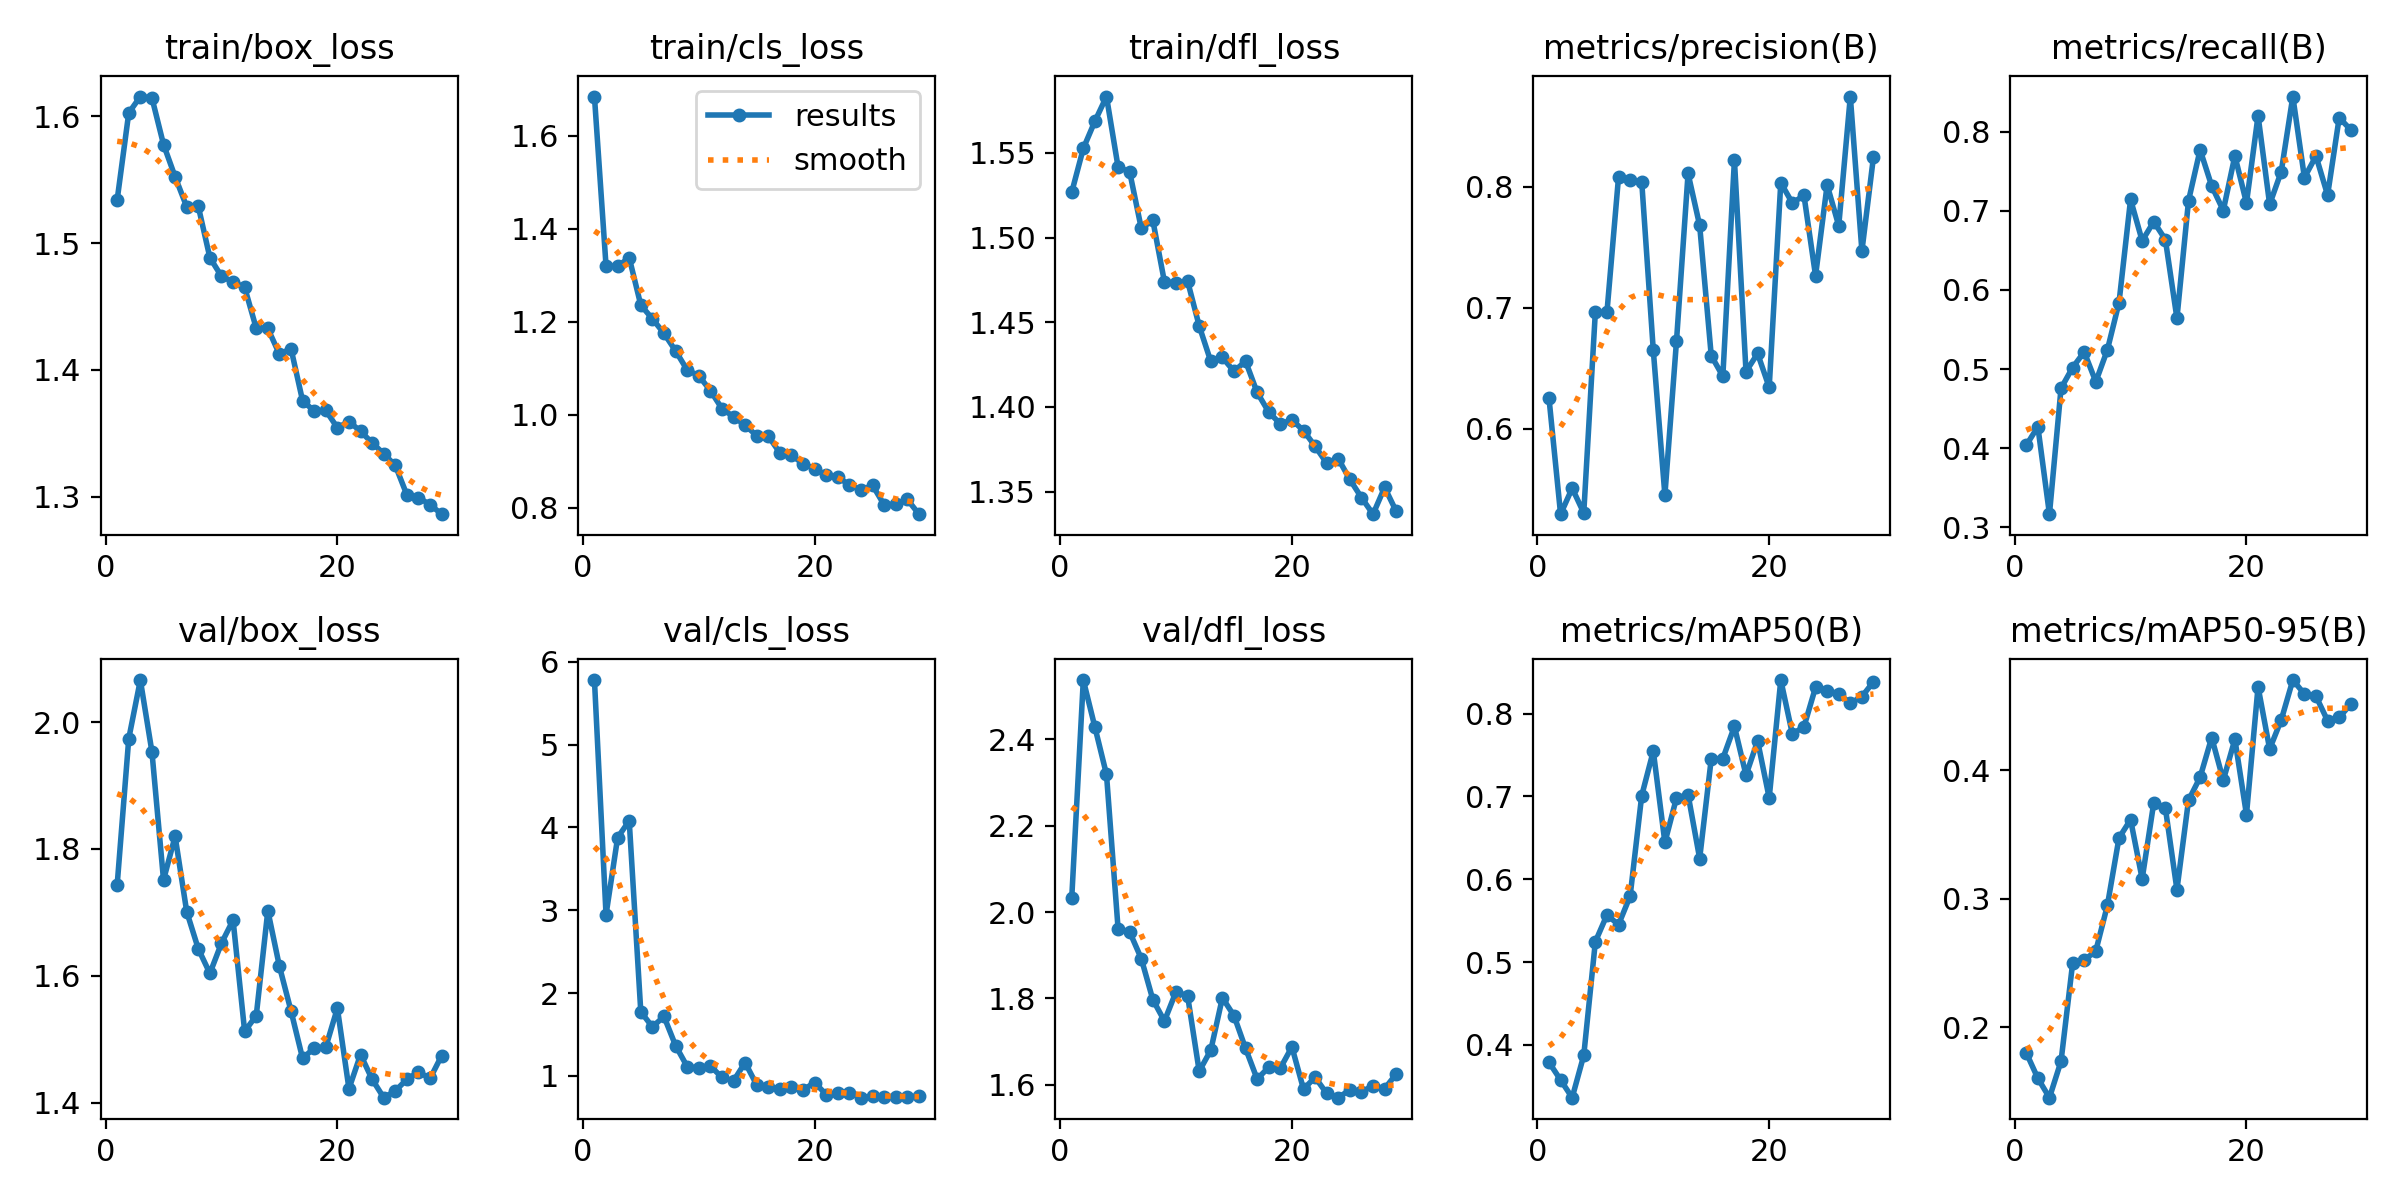

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

### Step 11: Load Test Dataset for Evaluation

Prepare test data using Supervision's dataset loader to evaluate model performance.

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

ds.classes

['helmet', 'no-helmet', 'no-vest', 'person', 'vest']

### Step 12: Compute Mean Average Precision

Evaluate the trained model using mAP metrics (50, 75, and 50:95).

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

The mAP metrics are printed and the results are plotted.

In [ ]:
# epoch 50
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.3509694779068432
mAP 50 0.6848011254837602
mAP 75 0.33297930509643364


In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.3509694779068432
mAP 50 0.6848011254837602
mAP 75 0.33297930509643364


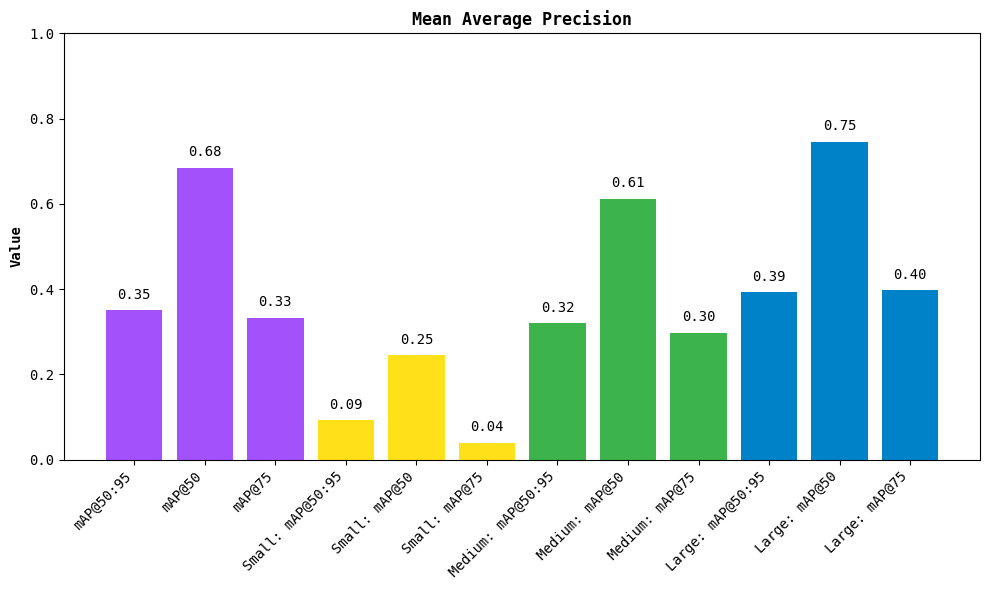

In [ ]:
map.plot()

### Step 13: Inference on Random Test Image

Run the trained model on a random test image and visualize detections.

In [ ]:
from ultralytics import YOLO
import supervision as sv

model = YOLO(f'/{HOME}/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


- Picks a random image.
- Runs the trained YOLOv12 model.
- Applies NMS (Non-Max Suppression) to clean overlapping boxes.

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

`plot_image` displays the final annotated image with predicted bounding boxes and labels.

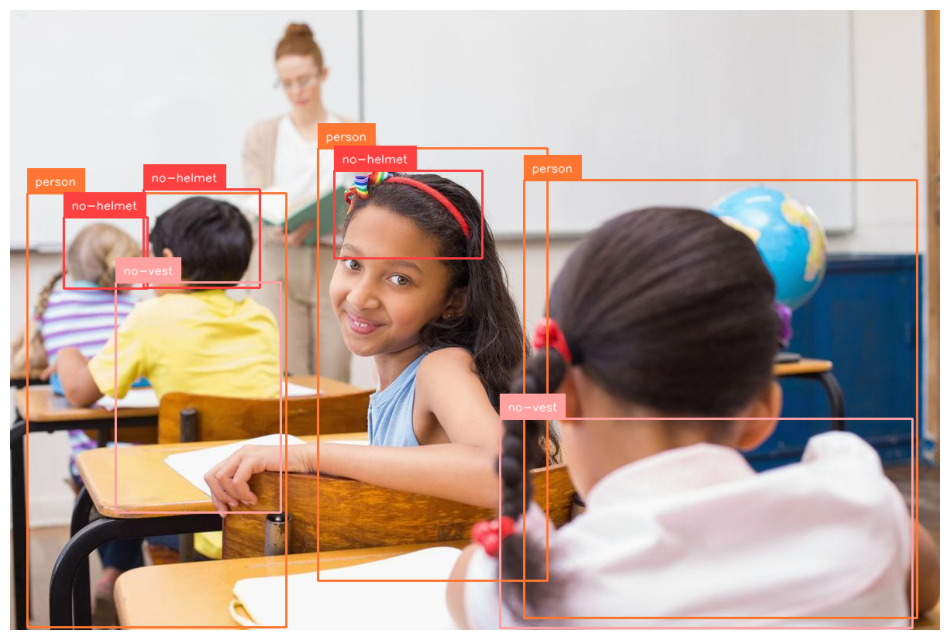

In [ ]:
sv.plot_image(annotated_image)

In [ ]:
# Get class names
class_names = model.names

# Count each class
from collections import Counter
detection_counts = Counter()

for class_id in detections.class_id:
    class_name = class_names[class_id]
    detection_counts[class_name] += 1

In [ ]:
# Safety equipment counts
helmet_count = detection_counts.get('Hardhat', 0) + detection_counts.get('helmet', 0)
no_helmet_count = detection_counts.get('NO-Hardhat', 0) + detection_counts.get('no-helmet', 0)
vest_count = detection_counts.get('Safety Vest', 0) + detection_counts.get('vest', 0)
no_vest_count = detection_counts.get('NO-Safety Vest', 0) + detection_counts.get('no-vest', 0)
person_count = detection_counts.get('Person', 0) + detection_counts.get('person', 0)

print(f"People Detected: {person_count}")
print(f"With Helmet: {helmet_count}")
print(f"No Helmet: {no_helmet_count}")
print(f"With Vest: {vest_count}")
print(f"No Vest: {no_vest_count}")

People Detected: 3
With Helmet: 0
No Helmet: 3
With Vest: 0
No Vest: 2


In [ ]:
# ANNOTATE IMAGE WITH COUNTS

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

In [ ]:
# Add summary text on image
import cv2
import numpy as np

# Create summary overlay
overlay = annotated_image.copy()
h, w = overlay.shape[:2]

# Background for text
cv2.rectangle(overlay, (10, 10), (350, 200), (0, 0, 0), -1)
annotated_image = cv2.addWeighted(annotated_image, 0.7, overlay, 0.3, 0)

# Add text
font = cv2.FONT_HERSHEY_SIMPLEX
y_offset = 40
cv2.putText(annotated_image, "DETECTION SUMMARY", (20, y_offset), font, 0.7, (255, 255, 255), 2)
y_offset += 30
cv2.putText(annotated_image, f"People: {person_count}", (20, y_offset), font, 0.6, (255, 255, 255), 2)
y_offset += 25
cv2.putText(annotated_image, f"Helmet: {helmet_count} | No Helmet: {no_helmet_count}", (20, y_offset), font, 0.5, (0, 255, 0) if no_helmet_count == 0 else (0, 165, 255), 2)
y_offset += 25
cv2.putText(annotated_image, f"Vest: {vest_count} | No Vest: {no_vest_count}", (20, y_offset), font, 0.5, (0, 255, 0) if no_vest_count == 0 else (0, 165, 255), 2)
y_offset += 30

# Compliance status
if no_helmet_count == 0 and no_vest_count == 0 and person_count > 0:
    cv2.putText(annotated_image, "STATUS: COMPLIANT", (20, y_offset), font, 0.6, (0, 255, 0), 2)
else:
    cv2.putText(annotated_image, "STATUS: NON-COMPLIANT", (20, y_offset), font, 0.6, (0, 0, 255), 2)



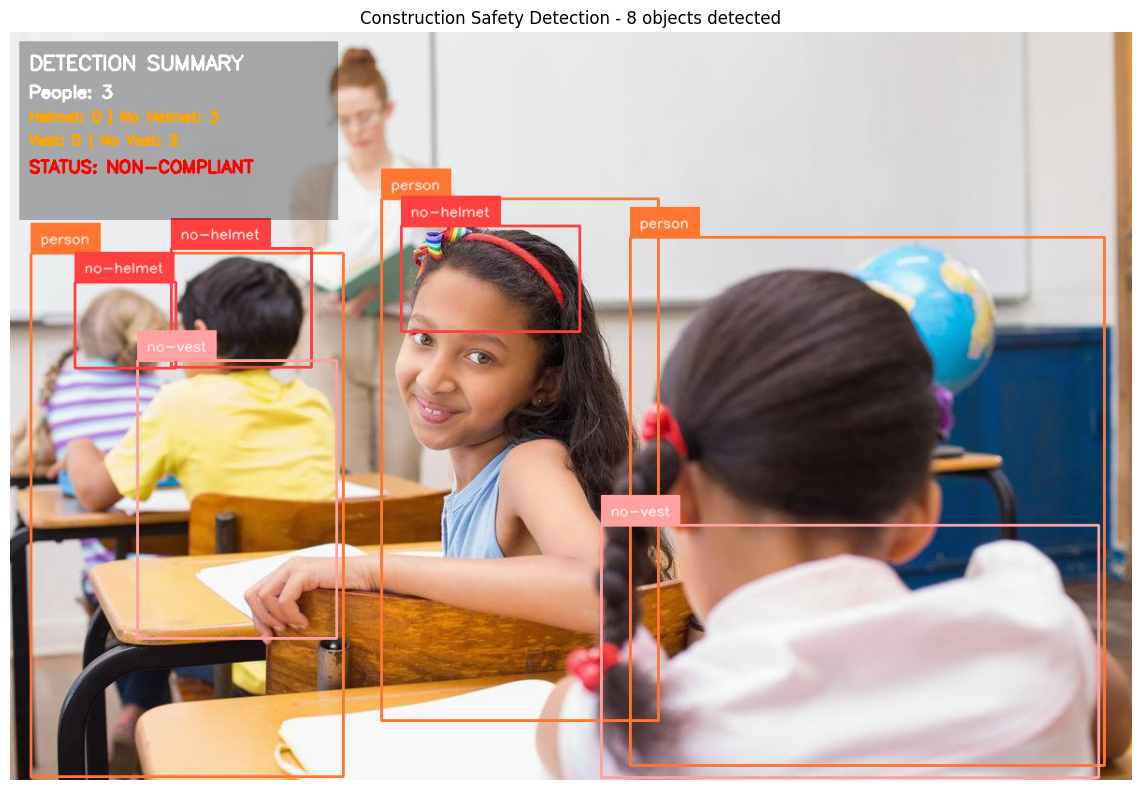

In [ ]:
# Display
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Construction Safety Detection - {len(detections)} objects detected")
plt.tight_layout()
plt.show()

### 🔍 **Conclusion**

Over the course of 50 training epochs using YOLOv12m, the model showed consistent improvements in all performance metrics, including precision (P), recall (R), mean average precision at IoU=0.50 (mAP@50), and mean average precision across IoU thresholds (mAP@50-95).

#### 📈 Performance Summary:
- **Initial performance** (Epoch 1):  
  - mAP@50 = **0.379**, mAP@50-95 = **0.18**
- **Final performance** (Epoch 29):  
  - mAP@50 = **0.839**, mAP@50-95 = **0.452**
- **Validation with best.pt**:
  - Overall mAP@50 = **0.685**
  - Class-wise mAP@50:
    - Helmet: **0.946**
    - No-Helmet: **0.575**
    - No-Vest: **0.818**
    - Person: **0.935**
    - Vest: **0.887**

These results indicate a successful training process with high detection accuracy across all classes.

#### ✅ Problem Solved:
This hands-on training addressed the problem of detecting five object categories — **Helmet**, **No-Helmet**, **No-Vest**, **Person**, and **Vest** — in images. By fine-tuning the YOLOv12m model, we achieved strong object detection performance on a moderately sized train dataset (997 images) and validation dataset (119 images).

The results demonstrate YOLOv12m's efficiency and capability in solving real-world object detection tasks with relatively fast training time (~0.468 hours) and low model size (40.8MB).

This experiment validates YOLOv12m as a suitable choice for lightweight, accurate object detection in constrained environments.